In [868]:
# import libraries

import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, cohen_kappa_score, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict

from xgboost import XGBClassifier, plot_importance

RSEED=42

In [892]:
# read data
df=pd.read_csv('/Users/annelahann/neue-fische/RiffRefine/data/data_with_target.csv')
df.head()


,Unnamed: 0,track_id,album_comments,album_date_created,album_favorites,album_id,album_listens,album_title,album_tracks,album_type,artist_comments,artist_date_created,artist_favorites,artist_id,artist_name,artist_tags,set_split,set_subset,track_bit_rate,track_comments,track_date_created,track_duration,track_favorites,track_genre_top,track_genres,track_genres_all,track_interest,track_license,track_listens,track_number,track_title,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,chroma_cens_kurtosis_10,chroma_cens_kurtosis_11,chroma_cens_kurtosis_12,chroma_cens_max_01,chroma_cens_max_02,chroma_cens_max_03,chroma_cens_max_04,chroma_cens_max_05,chroma_cens_max_06,chroma_cens_max_07,chroma_cens_max_08,chroma_cens_max_09,chroma_cens_max_10,chroma_cens_max_11,chroma_cens_max_12,chroma_cens_mean_01,chroma_cens_mean_02,chroma_cens_mean_03,chroma_cens_mean_04,chroma_cens_mean_05,chroma_cens_mean_06,chroma_cens_mean_07,chroma_cens_mean_08,chroma_cens_mean_09,chroma_cens_mean_10,chroma_cens_mean_11,chroma_cens_mean_12,chroma_cens_median_01,chroma_cens_median_02,chroma_cens_median_03,chroma_cens_median_04,chroma_cens_median_05,chroma_cens_median_06,chroma_cens_median_07,chroma_cens_median_08,chroma_cens_median_09,chroma_cens_median_10,chroma_cens_median_11,chroma_cens_median_12,chroma_cens_min_01,chroma_cens_min_02,chroma_cens_min_03,chroma_cens_min_04,chroma_cens_min_05,chroma_cens_min_06,chroma_cens_min_07,chroma_cens_min_08,chroma_cens_min_09,chroma_cens_min_10,chroma_cens_min_11,chroma_cens_min_12,chroma_cens_skew_01,chroma_cens_skew_02,chroma_cens_skew_03,chroma_cens_skew_04,chroma_cens_skew_05,chroma_cens_skew_06,chroma_cens_skew_07,chroma_cens_skew_08,chroma_cens_skew_09,chroma_cens_skew_10,chroma_cens_skew_11,chroma_cens_skew_12,chroma_cens_std_01,chroma_cens_std_02,chroma_cens_std_03,chroma_cens_std_04,chroma_cens_std_05,chroma_cens_std_06,chroma_cens_std_07,chroma_cens_std_08,chroma_cens_std_09,chroma_cens_std_10,chroma_cens_std_11,chroma_cens_std_12,chroma_cqt_kurtosis_01,chroma_cqt_kurtosis_02,chroma_cqt_kurtosis_03,chroma_cqt_kurtosis_04,chroma_cqt_kurtosis_05,chroma_cqt_kurtosis_06,chroma_cqt_kurtosis_07,chroma_cqt_kurtosis_08,chroma_cqt_kurtosis_09,chroma_cqt_kurtosis_10,chroma_cqt_kurtosis_11,chroma_cqt_kurtosis_12,chroma_cqt_max_01,chroma_cqt_max_02,chroma_cqt_max_03,chroma_cqt_max_04,chroma_cqt_max_05,chroma_cqt_max_06,chroma_cqt_max_07,chroma_cqt_max_08,chroma_cqt_max_09,chroma_cqt_max_10,chroma_cqt_max_11,chroma_cqt_max_12,chroma_cqt_mean_01,chroma_cqt_mean_02,chroma_cqt_mean_03,chroma_cqt_mean_04,chroma_cqt_mean_05,chroma_cqt_mean_06,chroma_cqt_mean_07,chroma_cqt_mean_08,chroma_cqt_mean_09,chroma_cqt_mean_10,chroma_cqt_mean_11,chroma_cqt_mean_12,chroma_cqt_median_01,chroma_cqt_median_02,chroma_cqt_median_03,chroma_cqt_median_04,chroma_cqt_median_05,chroma_cqt_median_06,chroma_cqt_median_07,chroma_cqt_median_08,chroma_cqt_median_09,chroma_cqt_median_10,chroma_cqt_median_11,chroma_cqt_median_12,chroma_cqt_min_01,chroma_cqt_min_02,chroma_cqt_min_03,chroma_cqt_min_04,chroma_cqt_min_05,chroma_cqt_min_06,chroma_cqt_min_07,chroma_cqt_min_08,chroma_cqt_min_09,chroma_cqt_min_10,chroma_cqt_min_11,chroma_cqt_min_12,chroma_cqt_skew_01,chroma_cqt_skew_02,chroma_cqt_skew_03,chroma_cqt_skew_04,chroma_cqt_skew_05,chroma_cqt_skew_06,chroma_cqt_skew_07,chroma_cqt_skew_08,chroma_cqt_skew_09,chroma_cqt_skew_10,chroma_cqt_skew_11,chroma_cqt_skew_12,chroma_cqt_std_01,chroma_cqt_std_02,chroma_cqt_std_03,chroma_cqt_std_04,chroma_cqt_std_05,chroma_cqt_std_06,chroma_cqt_std_07,chroma_cqt_std_08,chroma_cqt_std_09,chroma_cqt_std_10,chroma_cqt_std_11,chroma_cqt_std_12,chroma_stft_kurtosis_01,chroma_stft_kurtosis_02,chroma_stft_kurtosis_03,chroma_stft_kurtosis_04,chroma_stft_kurtosis_05,chroma_stft_kurtosis_06,chroma_stft_kurtosis_07,chroma_stft_kurtosis_08,chroma_stft_kurtosis_09,chro

In [870]:
#feature engineering
def limit_elements(lst):
    if len(lst) > 15:
        return 16
    else:
        return len(lst)
    
df['number_of_genres'] = df['track_genres'].apply(limit_elements)

df['number_of_genres_bins'] = pd.cut(df['number_of_genres'], bins=[0, 4, 8, 10, float('inf')], right=True)



In [871]:
df['listens_bins']=df['listens_bins']-1
df['listens_bins'].value_counts()

listens_bins
1    2054
2    2053
3    1960
0    1933
Name: count, dtype: int64

In [872]:
# feature engineering

def categorize_license(license):
    if "Public Domain" in license or "CC0" in license:
        return 1  # allows everything
    elif "NoDerivatives" in license and "NonCommercial" in license:
        return 4  
    elif "NonCommercial" in license:
        return 3  
    elif "Share Alike" in license:
        return 2  
    else:
        return 1  
    
df['license_category'] = df['track_license'].apply(categorize_license)



In [873]:
df['license_category'] = df['license_category'].astype('category')
df['track_genre_top'] = df['track_genre_top'].astype('category')
df['number_of_genres_bins'] = df['number_of_genres_bins'].astype('category')

In [874]:
# Define predictors and target variable

X = df[['track_genre_top','track_bit_rate','track_duration','album_information_bin','album_tracks','artist_bio_bin','track_title_char_count','track_number','license_category','other_website','soundcloud_website','number_of_genres_bins']]
y = df['listens_bins']
print(f"We have {X.shape[0]} observations in our dataset and {X.shape[1]} features")
print(f"Our target vector has also {y.shape[0]} values")


We have 8000 observations in our dataset and 12 features
Our target vector has also 8000 values


In [875]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   track_genre_top         8000 non-null   category
 1   track_bit_rate          8000 non-null   int64   
 2   track_duration          8000 non-null   int64   
 3   album_information_bin   8000 non-null   int64   
 4   album_tracks            8000 non-null   int64   
 5   artist_bio_bin          8000 non-null   int64   
 6   track_title_char_count  8000 non-null   int64   
 7   track_number            8000 non-null   int64   
 8   license_category        8000 non-null   category
 9   other_website           8000 non-null   bool    
 10  soundcloud_website      8000 non-null   bool    
 11  number_of_genres_bins   8000 non-null   category
dtypes: bool(2), category(3), int64(7)
memory usage: 477.5 KB


In [876]:
# Split into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
pd.set_option('display.max_columns', 600)
X_train.info()

X_train shape: (6400, 12)
X_test shape: (1600, 12)
y_train shape: (6400,)
y_test shape: (1600,)
<class 'pandas.core.frame.DataFrame'>
Index: 6400 entries, 1467 to 7270
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   track_genre_top         6400 non-null   category
 1   track_bit_rate          6400 non-null   int64   
 2   track_duration          6400 non-null   int64   
 3   album_information_bin   6400 non-null   int64   
 4   album_tracks            6400 non-null   int64   
 5   artist_bio_bin          6400 non-null   int64   
 6   track_title_char_count  6400 non-null   int64   
 7   track_number            6400 non-null   int64   
 8   license_category        6400 non-null   category
 9   other_website           6400 non-null   bool    
 10  soundcloud_website      6400 non-null   bool    
 11  number_of_genres_bins   6400 non-null   category
dtypes: bool(2), category(3), int64(7)
memo

In [877]:

xgb = XGBClassifier(random_state=RSEED, tree_method="hist", enable_categorical=True, use_label_encoder=False,max_depth=15,gamma=1.0,learning_rate=0.2,n_estimators=60)
xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=1.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=60, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [878]:
y_train_pred_xgb = xgb.predict(X_train)
y_test_pred_xgb = xgb.predict(X_test)

In [879]:
conf_matrix= confusion_matrix(y_train, y_train_pred_xgb)
accurate_classes = sum([conf_matrix[i][i] for i in range(len(conf_matrix))])
off_by_one = sum([conf_matrix[i][j] if abs(i - j) == 1 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
off_by_two = sum([conf_matrix[i][j] if abs(i - j) == 2 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
off_by_three = sum([conf_matrix[i][j] if abs(i - j) == 3 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])

print((100*accurate_classes/conf_matrix.sum()).round(1))
print((100*off_by_one/conf_matrix.sum()).round(1))
print((100*off_by_two/conf_matrix.sum()).round(1))
print((100*off_by_three/conf_matrix.sum()).round(1))
print('--------------------------------')
print(cohen_kappa_score(y_train, y_train_pred_xgb,weights='linear').round(3))

82.7
13.2
3.3
0.8
--------------------------------
0.825


In [880]:
conf_matrix= confusion_matrix(y_test, y_test_pred_xgb)
accurate_classes = sum([conf_matrix[i][i] for i in range(len(conf_matrix))])
off_by_one = sum([conf_matrix[i][j] if abs(i - j) == 1 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
off_by_two = sum([conf_matrix[i][j] if abs(i - j) == 2 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
off_by_three = sum([conf_matrix[i][j] if abs(i - j) == 3 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])

print((100*accurate_classes/conf_matrix.sum()).round(1))
print((100*off_by_one/conf_matrix.sum()).round(1))
print((100*off_by_two/conf_matrix.sum()).round(1))
print((100*off_by_three/conf_matrix.sum()).round(1))
print('--------------------------------')
print(cohen_kappa_score(y_test, y_test_pred_xgb,weights='linear').round(3))

59.2
33.1
6.3
1.4
--------------------------------
0.604


In [881]:
weights = 'linear'  
kappa_scorer = make_scorer(cohen_kappa_score, weights=weights)


In [882]:
grid_params = {
    'n_estimators': [58,60,65],
    'gamma': [1.0,1.05],
   # 'reg_lambda': [0.5,1.0,2.0],
    'max_depth': [14,15,16],
    'learning_rate': [0.2]
}

gs = GridSearchCV(
    XGBClassifier(random_state=RSEED, tree_method="hist",enable_categorical=True, use_label_encoder=False),
    grid_params,
    verbose=1,
    cv=3,
    n_jobs=-1,
    scoring=kappa_scorer)

In [883]:
xgb_gs = gs.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [884]:
xgb_gs.best_params_


{'gamma': 1.0, 'learning_rate': 0.2, 'max_depth': 15, 'n_estimators': 58}

In [885]:
best_model = xgb_gs.best_estimator_

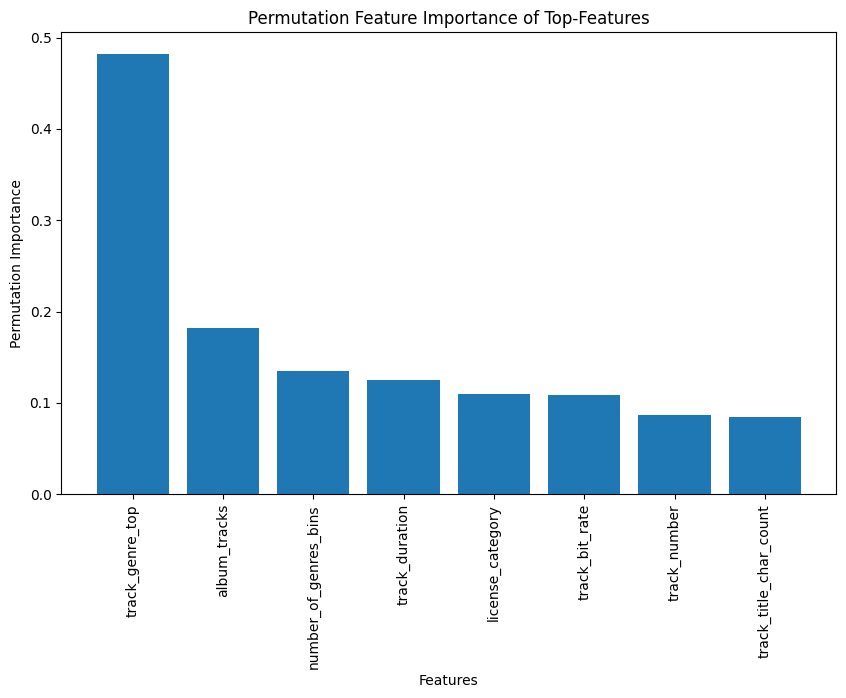

In [886]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(best_model, X_train, y_train,random_state=RSEED)

sorted_idx = perm_importance.importances_mean.argsort()[::-1]
feature_names = X.columns.tolist() 
top_features = 8
plt.figure(figsize=(10, 6))
plt.bar(range(top_features), perm_importance.importances_mean[sorted_idx][:top_features], align="center")
plt.xticks(range(top_features), [feature_names[i] for i in sorted_idx[:top_features]], rotation=90)
plt.xlabel('Features')
plt.ylabel('Permutation Importance')
plt.title('Permutation Feature Importance of Top-Features')
plt.show()

<Axes: title={'center': 'Feature importance'}, ylabel='Features'>

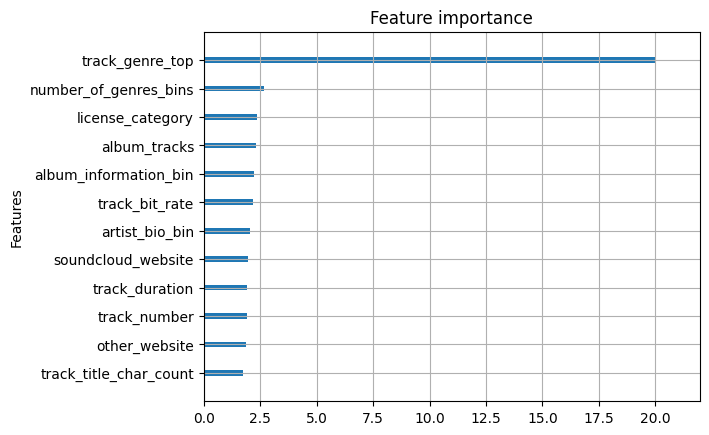

In [894]:
plot_importance(best_model, max_num_features = 15, xlabel='',title='Feature importance',show_values=False,importance_type='gain')

In [888]:
y_train_pred_xgb = best_model.predict(X_train)
y_test_pred_xgb = best_model.predict(X_test)

In [889]:
conf_matrix= confusion_matrix(y_train, y_train_pred_xgb)
accurate_classes = sum([conf_matrix[i][i] for i in range(len(conf_matrix))])
off_by_one = sum([conf_matrix[i][j] if abs(i - j) == 1 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
off_by_two = sum([conf_matrix[i][j] if abs(i - j) == 2 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
off_by_three = sum([conf_matrix[i][j] if abs(i - j) == 3 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])

print((100*accurate_classes/conf_matrix.sum()).round(1))
print((100*off_by_one/conf_matrix.sum()).round(1))
print((100*off_by_two/conf_matrix.sum()).round(1))
print((100*off_by_three/conf_matrix.sum()).round(1))
print('--------------------------------')
print(cohen_kappa_score(y_train, y_train_pred_xgb,weights='linear').round(3))

82.7
13.2
3.3
0.8
--------------------------------
0.825


In [890]:
conf_matrix= confusion_matrix(y_test, y_test_pred_xgb)
accurate_classes = sum([conf_matrix[i][i] for i in range(len(conf_matrix))])
off_by_one = sum([conf_matrix[i][j] if abs(i - j) == 1 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
off_by_two = sum([conf_matrix[i][j] if abs(i - j) == 2 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])
off_by_three = sum([conf_matrix[i][j] if abs(i - j) == 3 else 0 for i in range(len(conf_matrix)) for j in range(len(conf_matrix))])

print((100*accurate_classes/conf_matrix.sum()).round(1))
print((100*off_by_one/conf_matrix.sum()).round(1))
print((100*off_by_two/conf_matrix.sum()).round(1))
print((100*off_by_three/conf_matrix.sum()).round(1))
print('--------------------------------')
print(cohen_kappa_score(y_test, y_test_pred_xgb,weights='linear').round(3))


59.2
33.1
6.3
1.4
--------------------------------
0.604
